# Normalizing data for the SQL database

Normaling data to export into SQL database. Keep in mind, I won't be exporting all of the data there.

There are only around 100000 rows of data so we can just use prepare all everything through pandas and insert the tables to PostgreSQL in bulk.

Otherwise using staging tables would be a good idea.

In [28]:
# Module imports
# standard library imports

import os
import ast
import itertools
import re
import ast


# third-party imports
import numpy as np
import pandas as pd

# sqlalchemy
from sqlalchemy import create_engine

In [29]:
# connection settings
try:
    with open('../data/_credentials/db_config.txt', 'r') as f:
        db_config = eval(f.read())
    if not isinstance(db_config, dict):
        db_config = None
except:
    db_config = None

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(   db_config['user'],
                                                            db_config['pwd'],
                                                            db_config['host'],
                                                            db_config['port'],
                                                            db_config['db'])

In [30]:
# creating connector
engine = create_engine(connection_string, connect_args={'sslmode':'require'})

In [31]:
# helper functions

## Database Schema


## ER Diagram
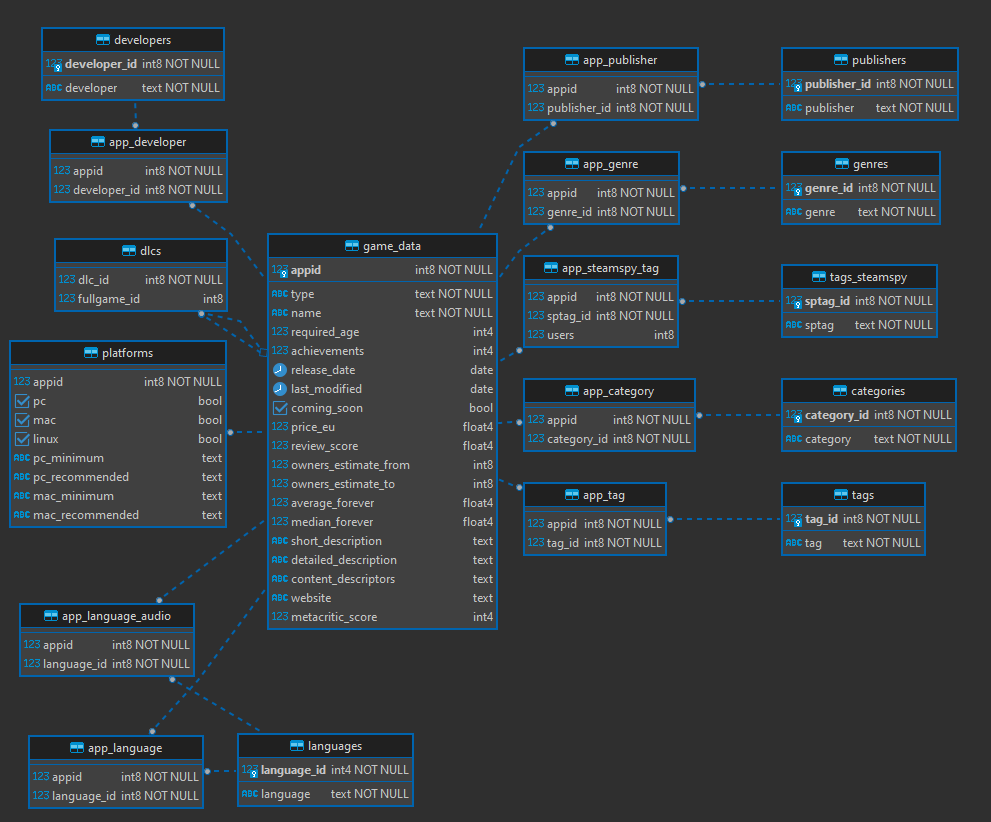

## Loading data into pandas

In [32]:
# Loading data tables
steam = pd.read_csv('../data/export/steam.csv', dtype={
    'fullgame': 'Int64',
    'total_positive': 'Int64',
    'total_negative': 'Int64'})
missing_ids = pd.read_csv('../data/export/missing_ids.csv')
steam_description_data = pd.read_csv('../data/export/steam_description_data.csv')
steam_media_data = pd.read_csv('../data/export/steam_media_data.csv')
steam_optional = pd.read_csv('../data/export/steam_optional.csv')
steam_packages_info = pd.read_csv('../data/export/steam_packages_info.csv')
steam_requirements_data = pd.read_csv('../data/export/steam_requirements_data.csv')
steam_support_info = pd.read_csv('../data/export/steam_support_info.csv')
steamspy_tag_data = pd.read_csv('../data/export/steamspy_tag_data.csv')

## Creating tables in database

## Creating fact tables

### game_data

Main table with the game data

| Field                | Type     | Nullable | Key     | Description                      |
| -------------------- | -------- | -------- | ------- | -------------------------------- |
| appid                | int      | False    | Primary | appid                            |
| type                 | text     | False    |         | application type (game/dlc/etc)  |
| name                 | text     | False    |         | application name                 |
| required_age         | int      | True     |         | minimum required age             |
| achievements         | int      | True     |         | number of achievements           |
| release_date         | datetime | True     |         | release date                     |
| last_modified        | datetime | False    |         | last modified date               |
| coming_soon          | boolean  | False    |         | is released                      |
| price_eu             | float64  | True     |         | price in eu for european region  |
| review_score         | float64  | True     |         | normalized review score          |
| owners_estimate_from | int      | True     |         | Estimated owners from (SteamSpy) |
| owners_estimate_to   | int      | True     |         | Estimated owners to (SteamSpy)   |
| average_forever      | float64  | True     |         | average playtime                 |
| median_forever       | float64  | True     |         | median playtime                  |
| short_description    | text     | True     |         | Short game description           |
| detailed_description | text     | True     |         | Detailed game description        |
| content_descriptors  | text     | True     |         | Rated content description        |
| website              | text     | True     |         | Game website                     |
| metacritic_score     | int      | True     |         | Metacritic review score          |

Merging tables on appid: 
* steam[[
    'appid', 'type', 'name', 'required_age', 'achievements', 'release_date', 'last_modified', 'coming_soon',
     'price_eu', 'review_score', 'owners_estimate_from', 'owners_estimate_to', 'average_forever', 'median_forever']]
* steam_description_data[['short_description', 'detailed_description']]
* steam_optional[['content_descriptors', 'metacritic_score']]
* steam_support_info[['website']]
    

In [33]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(steam.sample(2))

,appid,type,name,required_age,dlc,fullgame,supported_languages,developers,publishers,packages,platforms,categories,genres,achievements,release_date,last_modified,supported_audio,coming_soon,price,review_score,total_positive,total_negative,rating,owners,average_forever,median_forever,tags
95788,1837440,game,Pyramid Quest,0,NaN,<NA>,['English'],['EntwicklerX'],['EntwicklerX'],[661076],['windows'],"['Single-player', 'Steam Achievements', 'Full ...","['Adventure', 'Indie']",16,2022-01-20 00:00:00,1642691053,NaN,False,8.19,7.0,10,0,75.707088,0-20000,0.0,0.0,"['Adventure', 'Arcade', 'Platformer', 'Puzzle'..."
77747,1543380,game,I Fetch Rocks,0,NaN,<NA>,['English'],['SarumXR'],['SarumXR'],[545023],['windows'],"['Single-player', 'Steam Cloud', 'Steam Leader...","['Simulation', 'Early Access']",0,2022-03-03 00:00:00,1653666854,NaN,False,13.29,7.0,47,1,83.068020,0-20000,0.0,0.0,"['Space', 'Simulation', 'Sandbox', 'Physics', ..."


In [34]:
# transforming steam data
# release_date
steam['release_date'] = pd.to_datetime(steam['release_date'])
# last_modified
steam['last_modified'] = pd.to_datetime(steam['last_modified'])
# owners_estimate_from
# owners_estimate_to
steam[['owners_estimate_from', 'owners_estimate_to']] = steam['owners'].str.split('-', 1, expand=True)
steam['owners_estimate_from'] = steam['owners_estimate_from'].astype('float').astype('Int32')
steam['owners_estimate_to'] = steam['owners_estimate_to'].astype('float').astype('Int32')
# Merging tables. Appid should be unique for each table so left merging to steam is safe
game_data = steam[['appid', 'type', 'name', 'required_age', 'achievements', 'release_date', 'last_modified', 'coming_soon',
     'price', 'review_score', 'owners_estimate_from', 'owners_estimate_to', 'average_forever', 'median_forever'
     ]].merge(steam_description_data[['appid', 'short_description', 'detailed_description']], left_on='appid', right_on='appid', how='left')
game_data = game_data.merge(steam_optional[['appid', 'content_descriptors', 'metacritic_score']], left_on='appid', right_on='appid', how='left')
game_data = game_data.merge(steam_support_info[['appid', 'website']], left_on='appid', right_on='appid', how='left')

In [35]:
game_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108854 entries, 0 to 108853
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   appid                 108854 non-null  int64         
 1   type                  108854 non-null  object        
 2   name                  108854 non-null  object        
 3   required_age          108854 non-null  int64         
 4   achievements          108854 non-null  int64         
 5   release_date          101103 non-null  datetime64[ns]
 6   last_modified         108854 non-null  datetime64[ns]
 7   coming_soon           108854 non-null  bool          
 8   price                 95883 non-null   float64       
 9   review_score          108854 non-null  float64       
 10  owners_estimate_from  105901 non-null  Int32         
 11  owners_estimate_to    105901 non-null  Int32         
 12  average_forever       105901 non-null  float64       
 13 

In [36]:
game_data.sample(3)

,appid,type,name,required_age,achievements,release_date,last_modified,coming_soon,price,review_score,owners_estimate_from,owners_estimate_to,average_forever,median_forever,short_description,detailed_description,content_descriptors,metacritic_score,website
104851,2012030,game,Uncounted Isles,0,0,NaT,1970-01-01 00:00:01.662888947,True,NaN,0.0,<NA>,<NA>,NaN,NaN,Travel the Islands of the Uncounted Isle Archi...,⚔ Welcome Adventurer to the Uncounted Isles! ⚔...,NaN,NaN,https://uncountedisles.com
79959,1580150,game,Between Time: Escape Room,0,5,2021-09-15,1970-01-01 00:00:01.650908069,False,9.49,8.0,20000,50000,0.0,0.0,You are going to steal a time machine. In this...,<i>You are going to travel through time to ste...,NaN,NaN,NaN
32140,767930,game,Assault Spy,0,29,2018-10-02,1970-01-01 00:00:01.599755702,False,19.99,8.0,0,20000,162.0,162.0,"Dash, evade, and smash your way to the truth a...","<img src=""https://cdn.akamai.steamstatic.com/s...",NaN,NaN,https://assaultspy.com


### languages

| Field       | Type   | Nullable | Key     | Description |
| ----------- | ------ | -------- | ------- | ----------- |
| language_id | int    | False    | Primary | Language ID |
| language    | string | False    |         | Language    |

Get the unique languages from steam.supported_languages and steam.supported_audio, and sort them by value.

In [37]:
temp_df = steam[['appid', 'supported_languages', 'supported_audio']].copy()
# getting text languages
def language_cleanup(language_string):
    """
        Cleaning up language string from the unneeded characters and
        returning the list of cleaned up languages
        Parameters:
            language_string : string,
        Returns:
            list of cleaned up languages
    """
    re_mask = r'.((?:[A-Z][a-zA-Z \-\']*[a-z]+)+).?'
    try:
        language_string = language_string.replace('\\\'\\','')
        result1 = re.findall(re_mask, language_string)
        result = [x.strip() for x in result1]
    except:
        result = []
    return result

# cleaning up language strings. This is a temporary measure that should be removed after the clean up process is fixed
temp_df['supported_audio'] = temp_df['supported_audio'].apply(language_cleanup)
temp_df['supported_audio'] = temp_df['supported_audio'].fillna("").apply(list)
temp_df['supported_languages'] = temp_df['supported_languages'].apply(language_cleanup)                            
temp_df['supported_languages'] = temp_df['supported_languages'].fillna("").apply(list)

# getting the list of unique languages, removing nulls and sorting
language_df = pd.concat(
    [
        pd.DataFrame(temp_df['supported_languages'].explode().unique(), columns=['language']),
        pd.DataFrame(temp_df['supported_audio'].explode().unique(), columns=['language'])
    ]
).dropna().drop_duplicates().sort_values(by='language').reset_index(drop=True)
language_df.index.name='language_id'

In [38]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(language_df.head(10))

,language
language_id,
0,Afrikaans
1,Albanian
2,Amharic
3,Arabic
4,Armenian
5,Assamese
6,Azerbaijani
7,Bangla
8,Basque


### developers

| Field       | Type   | Nullable | Key     | Description |
| ------------ | ------ | -------- | ------- | ------------ |
| developer_id | int    | False    | Primary | Developer ID |
| developer    | string | False    |         | Developer    |

In [39]:
temp_df = steam[['appid', 'developers']].copy()
def list_check(value):
    try:
        result = ast.literal_eval(value)
    except:
        result = [value]
    return result
temp_df['developers'] = temp_df[temp_df['developers'].notnull()]['developers'].apply(list_check)

# getting the list of unique developers, removing nulls and sorting
developers_df = (
    pd.DataFrame(temp_df['developers'].explode().unique(), columns=['developer'])
    .dropna()
    .drop_duplicates()
    .sort_values(by='developer')
    .reset_index(drop=True)
)
developers_df.index.name='developer_id'

In [40]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(developers_df.sample(10))

,developer
developer_id,
18036,Hongke Luo
29577,OpenTTD
42855,Vainture Studio
9547,Dama Dama Games
46059,bitBerg
44396,William Lucht
28194,Nick Ramsay
9074,CyberConnect2
17002,HEAT REBORN DEV TEAM


### publishers

| Field        | Type   | Nullable | Key     | Description  |
| ------------ | ------ | -------- | ------- | ------------ |
| publisher_id | int    | False    | Primary | Publisher ID |
| publisher    | string | False    |         | Publisher    |

In [75]:
temp_df = steam[['appid', 'publishers']].copy()
def list_check(value):
    try:
        result = ast.literal_eval(value)
    except:
        result = [value]
    return result
temp_df['publishers'] = temp_df[temp_df['publishers'].notnull()]['publishers'].apply(list_check)
# getting the list of unique publishers, removing nulls and sorting
publishers_df = (
    pd.DataFrame(temp_df['publishers'].explode().unique(), columns=['publisher'])
    .dropna()
    .drop_duplicates()
    .sort_values(by='publisher')
    .reset_index(drop=True)
)
publishers_df.index.name='publisher_id'

In [76]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(publishers_df.tail(10))

,publisher
publisher_id,
41154,유진게임즈
41155,한국IT전문학교
41156,（Hong Kong）GKD
41157,（Hong Kong）GKD Game Studio
41158,（偽）苅田町役所
41159,𓃴 𓃵 𓃲
41160,𝓓𝓻𝔂❆𝓘𝓬𝓮
41161,👀
41162,📚瓜山书坊Guashan Bookshop


### platforms

#### platforms
| Field           | Type    | Nullable | Key     | Description |
| --------------- | ------- | -------- | ------- | ----------- |
| appid           | int     | False    | Primary | App ID      |
| windows         | boolean | False    |         |             |
| mac             | boolean | False    |         |             |
| linux           | boolean | False    |         |             |
| pc_minimum      | string  | True     |         |             |
| pc_recommended  | string  | True     |         |             |
| mac_minimum     | string  | True     |         |             |
| mac_recommended | string  | True     |         |             |

In [71]:
# copying dataframes
temp = steam[['appid', 'platforms']].copy()
temp1 = steam_requirements_data[['appid', 'pc_minimum', 'pc_recommended', 'mac_minimum', 'mac_recommended']].copy()
# parsing strings to lists
temp['platforms'] = temp['platforms'].apply(ast.literal_eval)
# exploding columns
temp = temp.explode('platforms')
# crosstabing to make boolean columns for each platform
temp = pd.crosstab(temp['appid'], temp['platforms'], dropna=False).replace({0: False, 1: True})
# mergingn with requirements
platforms_df = temp.merge(temp1, left_index=True, right_on='appid', how='left').reset_index(drop=True)
platforms_df = platforms_df[['appid', 'windows', 'mac', 'linux', 'pc_minimum', 'pc_recommended', 'mac_minimum', 'mac_recommended']]

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(platforms_df.tail(10))

### categories

| Field       | Type   | Nullable | Key     | Description |
| ----------- | ------ | -------- | ------- | ----------- |
| category_id | int    | False    | Primary | Category ID |
| category    | string | False    |         | Category    |

In [77]:
temp_df = steam[['appid', 'categories']].copy()

temp_df['categories'] = temp_df[temp_df['categories'].notnull()]['categories'].apply(list_check)
# getting the list of unique publishers, removing nulls and sorting
categories_df = (
    pd.DataFrame(temp_df['categories'].explode().unique(), columns=['category'])
    .dropna()
    .drop_duplicates()
    .sort_values(by='category')
    .reset_index(drop=True)
)
categories_df.index.name='category_id'

In [78]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(categories_df.tail(10))

,category
category_id,
27,Stats
28,Steam Achievements
29,Steam Cloud
30,Steam Leaderboards
31,Steam Trading Cards
32,Steam Turn Notifications
33,Steam Workshop
34,SteamVR Collectibles
35,VR Support


### genres

| Field    | Type   | Nullable | Key     | Description |
| -------- | ------ | -------- | ------- | ----------- |
| genre_id | int    | False    | Primary | Genre ID    |
| genre    | string | False    |         | Genre       |

In [82]:
temp_df = steam[['appid', 'genres']].copy()

temp_df['genres'] = temp_df[temp_df['genres'].notnull()]['genres'].apply(list_check)
# getting the list of unique publishers, removing nulls and sorting
genres_df = (
    pd.DataFrame(temp_df['genres'].explode().unique(), columns=['genre'])
    .dropna()
    .drop_duplicates()
    .sort_values(by='genre')
    .reset_index(drop=True)
)
genres_df.index.name='genre_id'

In [83]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(genres_df.tail(10))

,genre
genre_id,
23,Short
24,Simulation
25,Software Training
26,Sports
27,Strategy
28,Tutorial
29,Utilities
30,Video Production
31,Violent


### tags

| Field  | Type   | Nullable | Key     | Description |
| ------ | ------ | -------- | ------- | ----------- |
| tag_id | int    | False    | Primary | Tag ID      |
| tag    | string | False    |         | Tag         |

In [84]:
temp_df = steam[['appid', 'tags']].copy()

temp_df['tags'] = temp_df[temp_df['tags'].notnull()]['tags'].apply(list_check)
# getting the list of unique publishers, removing nulls and sorting
tags_df = (
    pd.DataFrame(temp_df['tags'].explode().unique(), columns=['tag'])
    .dropna()
    .drop_duplicates()
    .sort_values(by='tag')
    .reset_index(drop=True)
)
tags_df.index.name='tag_id'

In [85]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(tags_df.tail(10))

,tag
tag_id,
428,Well-Written
429,Werewolves
430,Western
431,Wholesome
432,Word Game
433,World War I
434,World War II
435,Wrestling
436,Zombies


### tags_steamspy

| Field    | Type   | Nullable | Key     | Description     |
| -------- | ------ | -------- | ------- | --------------- |
| sptag_id | int    | False    | Primary | SteamSpy Tag ID |
| sptag    | string | False    |         |                 |

In [95]:
tags_list = list(steamspy_tag_data.columns)
tags_list.remove('appid')
tags_list.sort()
sptags_df = pd.DataFrame(tags_list, columns=['sptag'])
sptags_df.index.name='sptag_id'

In [96]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(sptags_df.tail(10))

,sptag
sptag_id,
428,web_publishing
429,well_written
430,werewolves
431,western
432,wholesome
433,word_game
434,world_war_i
435,world_war_ii
436,wrestling


## ER Diagram
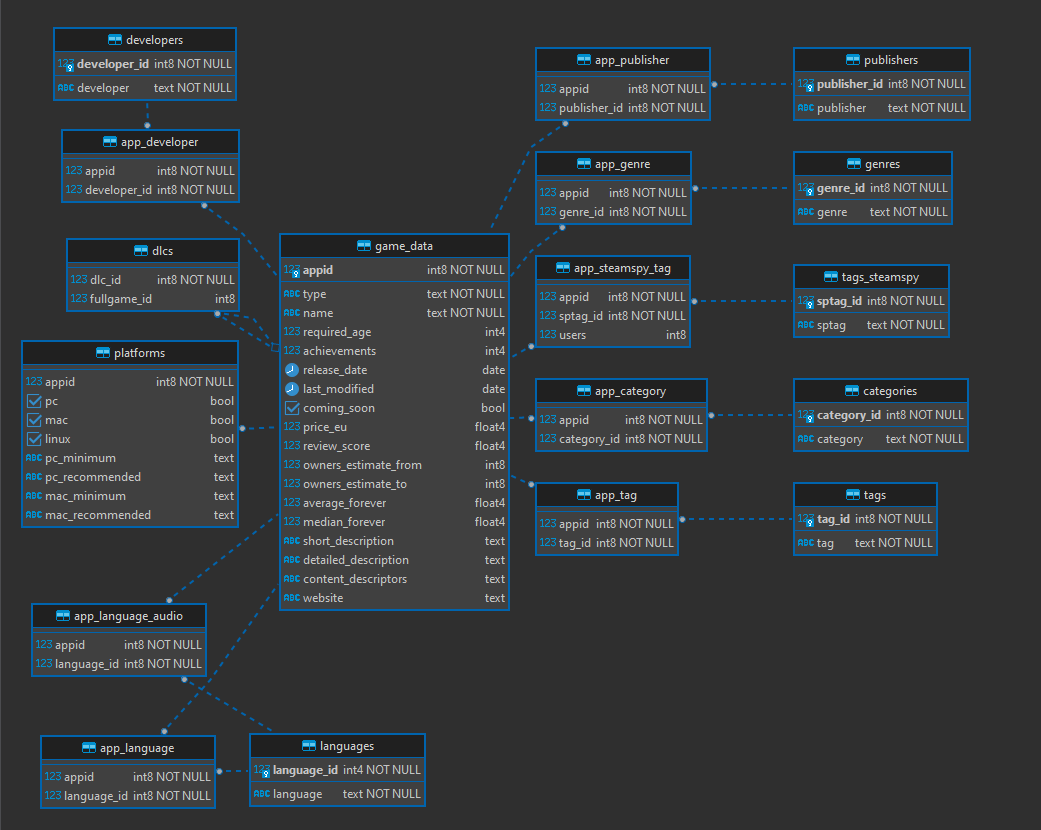

## Creating relations tables

### dlcs

| Field       | Type | Nullable | Key             | Description      |
| ----------- | ---- | -------- | --------------- | ---------------- |
| dlc_id      | int  | False    | game_data.appid | DLC App ID       |
| fullgame_id | int  | False    | game_data.appid | Main game App ID |

In [113]:
dlcs_df = steam.loc[steam.dlc.notnull(),['appid', 'dlc']].copy()

dlcs_df['dlc'] = dlcs_df['dlc'].apply(list_check)
dlcs_df = dlcs_df.explode('dlc')
dlcs_df['dlc'] = dlcs_df['dlc'].astype('Int64')

### app_language, app_language_audio

| Field       | Type | Nullable | Key                   | Description |
| ----------- | ---- | -------- | --------------------- | ----------- |
| appid       | int  | False    | game_data.appid       | App ID      |
| language_id | int  | False    | languages.language_id | Language ID |

Fields are the same for both tables.

We'll just get the unique appid -> language pairs here for a staging tables and get language_id through the SQL in the DB.

In [129]:
temp_df = steam[['appid', 'supported_languages', 'supported_audio']].copy()
# getting text languages
def language_cleanup(language_string):
    """
        Cleaning up language string from the unneeded characters and
        returning the list of cleaned up languages
        Parameters:
            language_string : string,
        Returns:
            list of cleaned up languages
    """
    re_mask = r'.((?:[A-Z][a-zA-Z \-\']*[a-z]+)+).?'
    try:
        language_string = language_string.replace('\\\'\\','')
        result1 = re.findall(re_mask, language_string)
        result = [x.strip() for x in result1]
    except:
        result = []
    return result

# cleaning up language strings. This is a temporary measure that should be removed after the clean up process is fixed
temp_df['supported_audio'] = temp_df['supported_audio'].apply(language_cleanup)
temp_df['supported_audio'] = temp_df['supported_audio'].fillna("").apply(list)
temp_df['supported_languages'] = temp_df['supported_languages'].apply(language_cleanup)                            
temp_df['supported_languages'] = temp_df['supported_languages'].fillna("").apply(list)

# creating dataframes
# app_language, app_language_audio
app_language_df = temp_df[['appid','supported_languages']].explode('supported_languages')
app_language_df = app_language_df.dropna(subset=['supported_languages'])
app_language_df = app_language_df.drop_duplicates()
app_language_audio_df = temp_df[['appid','supported_audio']].explode('supported_audio')
app_language_audio_df = app_language_audio_df.dropna(subset=['supported_audio'])
app_language_audio_df = app_language_audio_df.drop_duplicates()


In [125]:
app_language_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440661 entries, 0 to 108853
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   appid                440661 non-null  int64 
 1   supported_languages  440661 non-null  object
dtypes: int64(1), object(1)
memory usage: 10.1+ MB


In [126]:
app_language_df.sample(10)

,appid,supported_languages
96110,1842985,French
99249,1901960,English
13380,431640,Portuguese - Brazil
91321,1761260,German
68853,1386630,English
14954,459770,English
66083,1341050,Czech
20496,562220,Thai
84805,1668240,Spanish - Spain
53128,1123430,Korean


In [127]:
app_language_audio_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116296 entries, 0 to 108846
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   appid            116296 non-null  int64 
 1   supported_audio  116296 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.7+ MB


In [128]:
app_language_audio_df.sample(10)

,appid,supported_audio
20562,563101,English
49793,1073230,English
19828,551110,Korean
10624,382140,Russian
63401,1287060,French
54486,1146142,English
39680,899822,Japanese
53765,1134340,Romanian
56031,1170320,Japanese
85603,1680151,English


### app_developer

| Field        | Type | Nullable | Key                     | Description  |
| ------------ | ---- | -------- | ----------------------- | ------------ |
| appid        | int  | False    | game_data.appid         | App ID       |
| developer_id | int  | False    | developers.developer_id | Developer ID |

In [142]:
temp_df = steam[['appid', 'developers']].copy()
temp_df['developers'] = temp_df[temp_df['developers'].notnull()]['developers'].apply(list_check)

# getting the list of unique developers, removing nulls and sorting
app_developer_df = temp_df.explode('developers')
app_developer_df = app_developer_df.dropna(subset=['developers'])
app_developer_df = app_developer_df.drop_duplicates()

In [143]:
app_developer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119415 entries, 0 to 108853
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   appid       119415 non-null  int64 
 1   developers  119415 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.7+ MB


In [144]:
app_developer_df.sample(10)

,appid,developers
26038,661312,Hidden Achievement LLC
2549,220260,Giants Software
424,16465,"Monolith Productions, Inc."
11640,399420,Gabriel. H
40862,922290,Enthusiast Games
99314,1903420,Wa Tran
35440,826497,TAMSOFT
66339,1345430,Interface0625
10767,384750,Sólfar Studios
71697,1435440,Twintertainment


### app_publisher

| Field        | Type | Nullable | Key                     | Description  |
| ------------ | ---- | -------- | ----------------------- | ------------ |
| appid        | int  | False    | game_data.appid         | App ID       |
| publisher_id | int  | False    | publishers.publisher_id | Publisher ID |

In [145]:
temp_df = steam[['appid', 'publishers']].copy()
temp_df['publishers'] = temp_df[temp_df['publishers'].notnull()]['publishers'].apply(list_check)

# getting the list of unique developers, removing nulls and sorting
app_publisher_df = temp_df.explode('publishers')
app_publisher_df = app_publisher_df.dropna(subset=['publishers'])
app_publisher_df = app_publisher_df.drop_duplicates()

In [146]:
app_publisher_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113771 entries, 0 to 108853
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   appid       113771 non-null  int64 
 1   publishers  113771 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.6+ MB


In [147]:
app_publisher_df.sample(10)

,appid,publishers
85612,1680160,TigerQiuQiu
6414,313140,KPL
9828,369781,Ubisoft - San Francisco
30391,739730,Reliant
96141,1843610,Libretro
79169,1567450,Lion Loewe
28313,701970,Boogygames Studios
28062,697270,Felix Schröder
63432,1287240,Golden Orb
88484,1709660,Ural Hedgehog


### app_category

| Field       | Type | Nullable | Key                    | Description |
| ----------- | ---- | -------- | ---------------------- | ----------- |
| appid       | int  | False    | game_data.appid        | App ID      |
| category_id | int  | False    | categories.category_id | Category ID |

In [149]:
temp_df = steam[['appid', 'categories']].copy()
temp_df['categories'] = temp_df[temp_df['categories'].notnull()]['categories'].apply(list_check)

# getting the list of unique developers, removing nulls and sorting
app_category_df = temp_df.explode('categories')
app_category_df = app_category_df.dropna(subset=['categories'])
app_category_df = app_category_df.drop_duplicates()

In [150]:
app_category_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453765 entries, 0 to 108853
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   appid       453765 non-null  int64 
 1   categories  453765 non-null  object
dtypes: int64(1), object(1)
memory usage: 10.4+ MB


In [151]:
app_category_df.sample(10)

,appid,categories
10414,378530,Shared/Split Screen PvP
53006,1122596,Downloadable Content
51856,1105410,Partial Controller Support
86191,1687811,Full controller support
85101,1673800,Single-player
47921,1042800,PvP
86848,1695219,Downloadable Content
98120,1880230,Shared/Split Screen
53094,1122900,Single-player
79279,1569311,Co-op


### app_genre

| Field    | Type | Nullable | Key             | Description |
| -------- | ---- | -------- | --------------- | ----------- |
| appid    | int  | False    | game_data.appid | App ID      |
| genre_id | int  | False    | genres.genre_id | Genre ID    |

In [152]:
temp_df = steam[['appid', 'genres']].copy()
temp_df['genres'] = temp_df[temp_df['genres'].notnull()]['genres'].apply(list_check)

# getting the list of unique developers, removing nulls and sorting
app_genre_df = temp_df.explode('genres')
app_genre_df = app_genre_df.dropna(subset=['genres'])
app_genre_df = app_genre_df.drop_duplicates()

In [153]:
app_genre_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298943 entries, 0 to 108853
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   appid   298943 non-null  int64 
 1   genres  298943 non-null  object
dtypes: int64(1), object(1)
memory usage: 6.8+ MB


In [154]:
app_genre_df.sample(10)

,appid,genres
95060,1824580,Indie
27617,688940,Free to Play
64941,1315570,Software Training
94176,1809310,Indie
23144,607120,Simulation
64293,1302850,Adventure
60127,1231750,Casual
85319,1676041,Simulation
34144,803340,Adventure
62251,1267310,Action


### app_tag

| Field  | Type   | Nullable | Key     | Description |
| ------ | ------ | -------- | ------- | ----------- |
| tag_id | int    | False    | Primary | Tag ID      |
| tag    | string | False    |         | Tag         |

In [160]:
temp_df = steam[['appid', 'tags']].copy()
temp_df['tags'] = temp_df[temp_df['tags'].notnull()]['tags'].apply(list_check)

# getting the list of unique developers, removing nulls and sorting
app_tag_df = temp_df.explode('tags')
app_tag_df = app_tag_df.dropna(subset=['tags'])
app_tag_df = app_tag_df.drop_duplicates()

In [161]:
app_tag_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659193 entries, 0 to 106760
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   appid   659193 non-null  int64 
 1   tags    659193 non-null  object
dtypes: int64(1), object(1)
memory usage: 15.1+ MB


In [162]:
app_tag_df.sample(10)

,appid,tags
90268,1742450,Strategy
68733,1384540,Family Friendly
104956,2014750,2D Platformer
22,570,MOBA
51302,1097110,Exploration
90237,1741640,Dark Fantasy
52724,1118310,Classic
11560,397720,Simulation
3439,246740,First-Person
102591,1964780,Adventure


### app_steamspy_tag

| Field    | Type | Nullable | Key                    | Description                |
| -------- | ---- | -------- | ---------------------- | -------------------------- |
| appid    | int  | False    | game_data.appid        | App ID                     |
| sptag_id | int  | False    | tags_steamspy.sptag_id | SteamSpy Tag ID            |
| users    | int  | False    |                        | Number of users with a tag |

In [171]:
app_steamspy_tag_df = steamspy_tag_data.melt(id_vars=['appid'])
app_steamspy_tag_df = app_steamspy_tag_df[app_steamspy_tag_df['value'] > 0].reset_index(drop=True)
app_steamspy_tag_df.columns = ['appid', 'sptag', 'users']

In [172]:
app_steamspy_tag_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659193 entries, 0 to 659192
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   appid   659193 non-null  int64 
 1   sptag   659193 non-null  object
 2   users   659193 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 15.1+ MB


In [173]:
app_steamspy_tag_df.sample(10)

,appid,sptag,users
556312,1470870,singleplayer,83
100615,496230,arcade,10
30715,1841350,4_player_local,25
229017,1708570,early_access,304
329391,993200,indie,11
595463,1671180,strategy,59
600792,851890,supernatural,232
590529,891480,strategy,187
561057,1735160,singleplayer,17
167458,1377240,class_based,168


## Inserting data

### Adding fact tables

### Adding and transforming relation tables

## Testing data